In [1]:
%cd ..

/home/eli/AnacondaProjects/categorical_bpl


In [2]:
import argparse
import collections
import random
import pyro
import torch
import matplotlib.pyplot as plt
import numpy as np
import data_loader.data_loaders as module_data
import model.model as module_arch
from parse_config import ConfigParser
from trainer import Trainer

In [3]:
%matplotlib inline

In [4]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [5]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

In [6]:
Args = collections.namedtuple('Args', 'config resume device')
config = ConfigParser.from_args(Args(config='omniglot_config.json', resume=None, device=None))

In [7]:
logger = config.get_logger('train')

In [8]:
# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [9]:
# build model architecture, then print to console
model = config.init_obj('arch', module_arch)

In [10]:
model.resume_from_checkpoint('saved/models/Omniglot_GlimpseCategory/0506_152815/checkpoint-epoch900.pth')

In [11]:
validation_data = random.choice(list(valid_data_loader))[0]

In [12]:
path, prediction_data = model(observations=validation_data)

In [13]:
prediction_data = prediction_data.view(-1, 1, 28, 28)

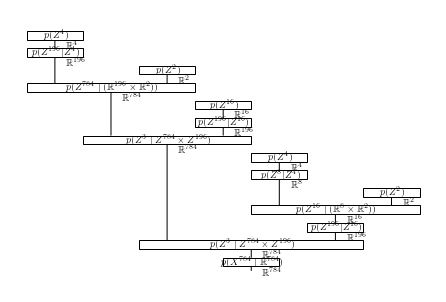

In [14]:
path.draw()

In [15]:
path.draw(path='omniglot_spair_string_diagram.pdf')

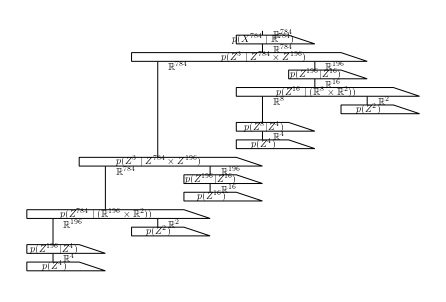

In [16]:
path.dagger().draw()

In [17]:
path.dagger().draw(path='omniglot_spair_string_diagram_dagger.pdf')

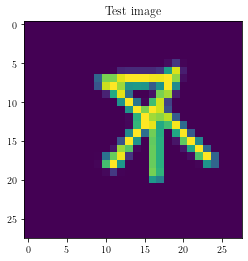

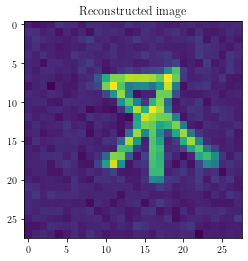

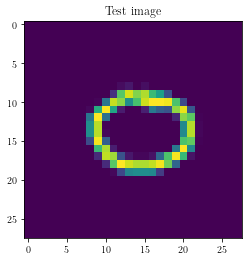

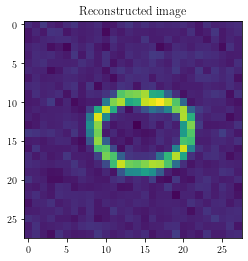

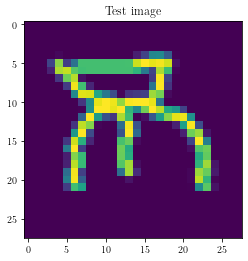

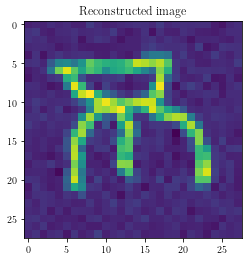

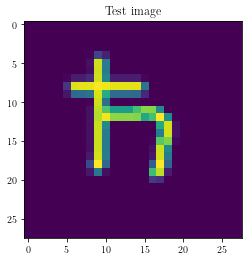

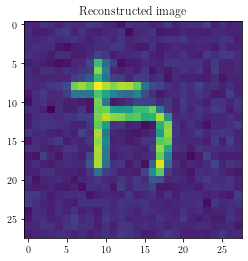

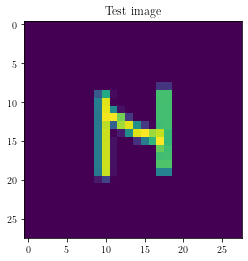

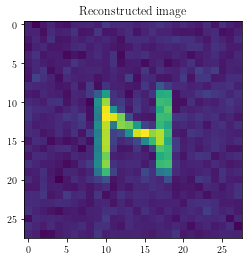

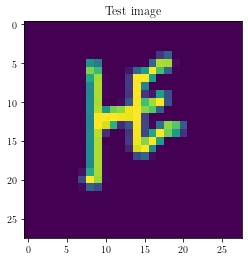

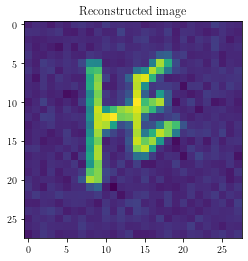

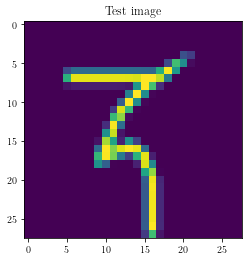

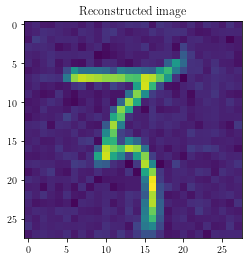

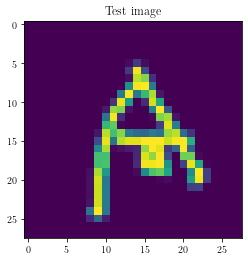

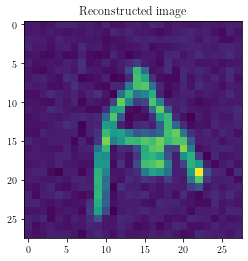

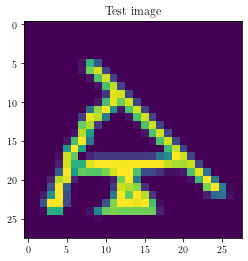

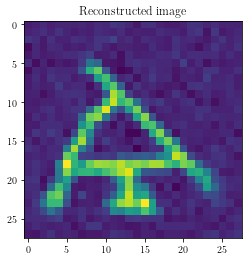

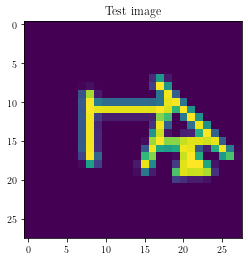

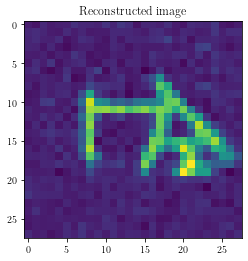

In [18]:
for k in np.random.randint(0, validation_data.shape[0], 10):
    image = validation_data[k].view(28, 28).detach().cpu().numpy()
    plt.title('Test image')
    plt.imshow(image)
    plt.show()

    prediction = prediction_data[k].view(28, 28).detach().cpu().numpy()
    plt.title('Reconstructed image')
    plt.imshow(prediction)
    plt.show()

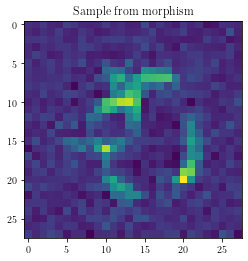

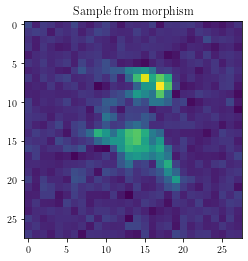

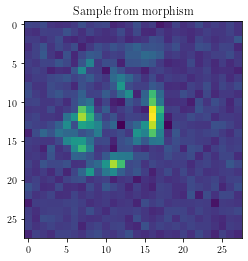

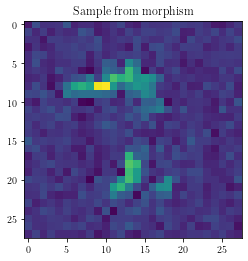

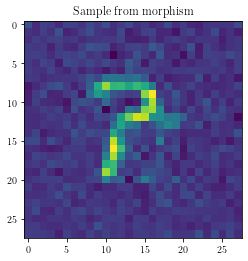

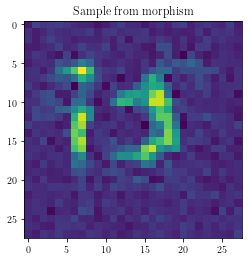

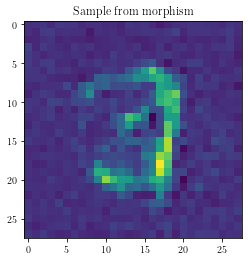

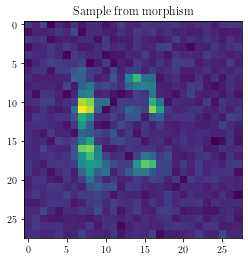

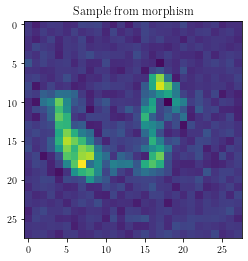

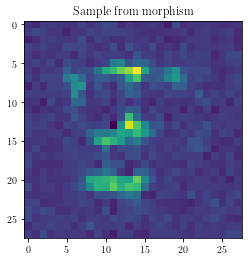

In [19]:
sample = path()
sample = sample.view(-1, 28, 28).detach().cpu().numpy()
    
for k in range(10):
    plt.title('Sample from morphism')
    plt.imshow(sample[k])
    plt.show()

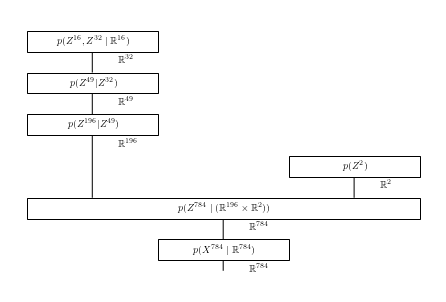

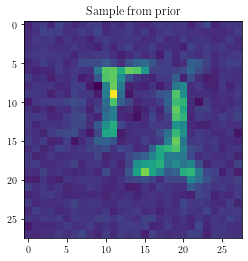

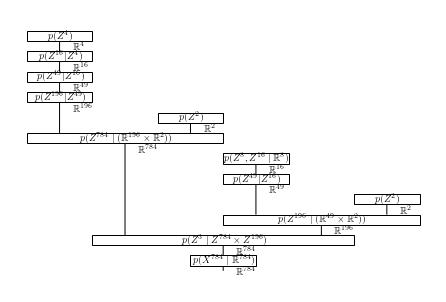

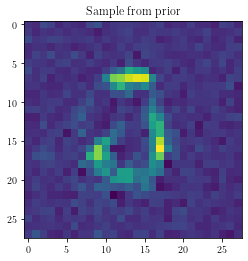

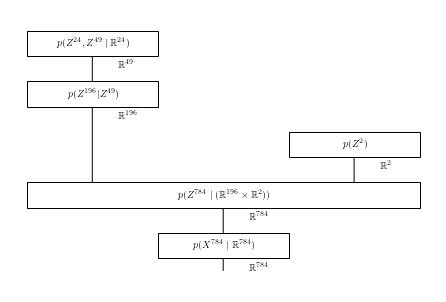

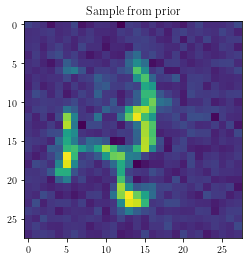

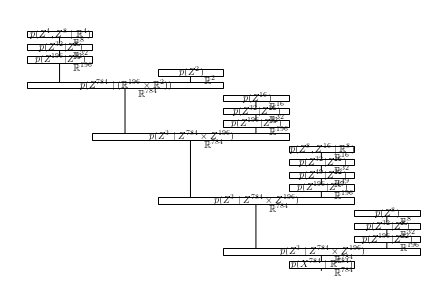

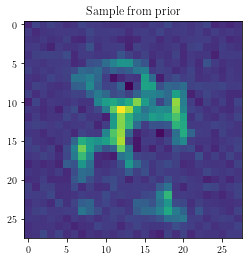

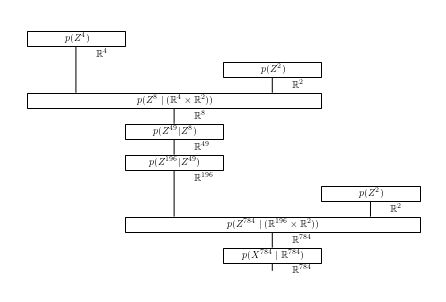

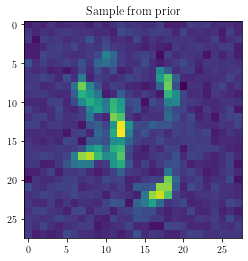

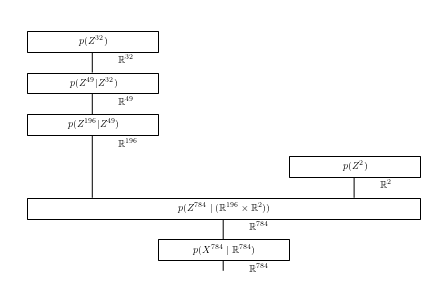

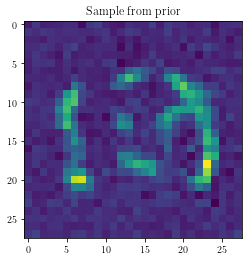

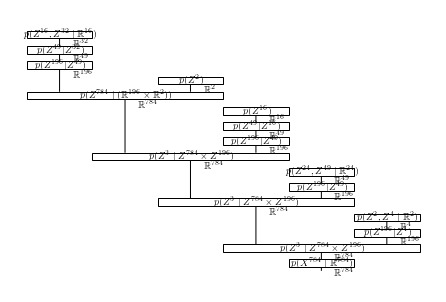

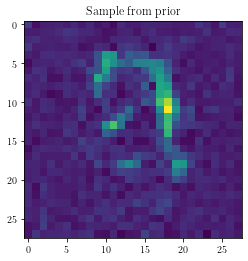

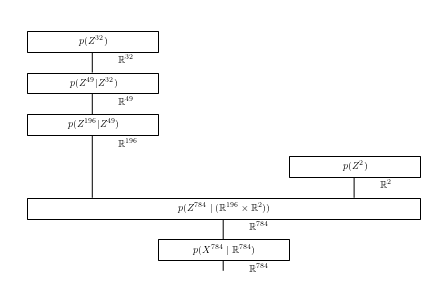

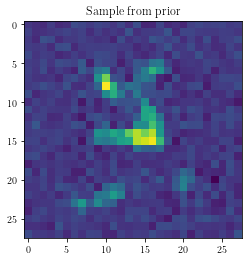

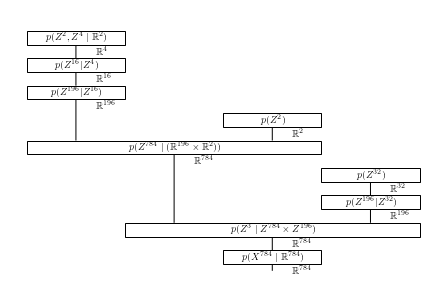

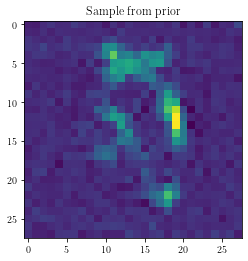

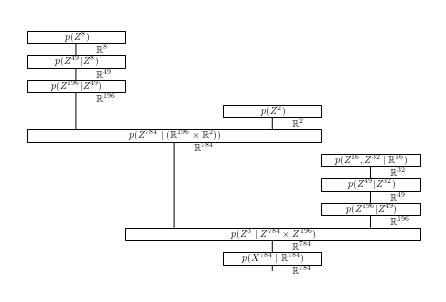

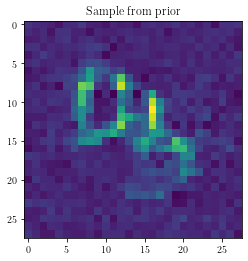

In [20]:
for k in range(10):
    path, sample = model(None)
    path.draw()
    sample = sample.view(28, 28).detach().cpu().numpy()
    plt.title('Sample from prior')
    plt.imshow(sample)
    plt.show()

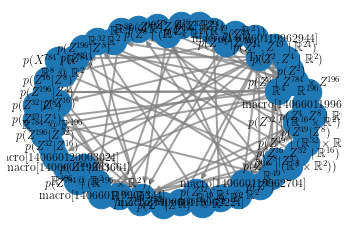

In [21]:
model._category.draw(filename='omniglot_free_category.pdf')

In [22]:
import torchvision

In [23]:
def show_img_grid(imgs, recons, path=None):
    from PIL import Image
    images = torch.cat((imgs, recons), dim=0)
    
    if path is None:
        grid = torchvision.utils.make_grid(images, nrow=imgs.shape[0])
        grid = grid.mul(255).add_(0.5).clamp_(0, 255).detach().permute(1, 2, 0).to('cpu', torch.uint8)
        img = Image.fromarray(grid.numpy())
        plt.imshow(img)
    else:
        torchvision.utils.save_image(images, path, nrow=imgs.shape[0])

In [24]:
show_img_grid(validation_data[:5], prediction_data[:5], path='omniglot_spair_reconstructions.pdf')

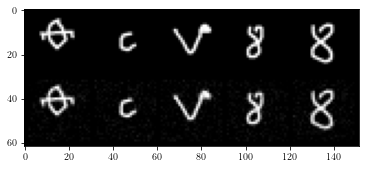

In [25]:
show_img_grid(validation_data[:5], prediction_data[:5])

In [26]:
optimizer = pyro.optim.StepLR({
    'optimizer': torch.optim.Adam,
    'optim_args': {
        "lr": 1e-3,
        "weight_decay": 0,
        "amsgrad": True
    },
    "step_size": 400,
    "gamma": 0.1,
})

In [27]:
from torch.nn.functional import binary_cross_entropy
from pyro.infer.enum import get_importance_trace

def bernoulli_log_marginal(model, guide, data, target, num_particles):
    log_weights = []
    for k in range(num_particles):
        model_trace, guide_trace = get_importance_trace("dense", 1, model, guide, (),
                                                        {'observations': data})
        predictions = model_trace.nodes['_RETURN']['value'][1]
        predictions = predictions.clamp(0., 1.).reshape(*data.shape)
        ll = binary_cross_entropy(predictions, data, reduction='sum').item()
        log_ratio = model_trace.log_prob_sum(lambda n, s: not s['is_observed']).item() -\
                    guide_trace.log_prob_sum().item()
        log_weights.append(ll + log_ratio)
    
    log_weights = torch.tensor(log_weights)
    log_num_particles = torch.log(torch.tensor(num_particles * 1.0))
    return torch.logsumexp(log_weights - log_num_particles, 0).item() / data.shape[0]

In [28]:
trainer = Trainer(model, [bernoulli_log_marginal], optimizer, config=config,
                  data_loader=data_loader,
                  valid_data_loader=valid_data_loader)

In [29]:
valid_metrics = trainer._valid_epoch(1200)

In [30]:
for k, v in valid_metrics.items():
    valid_metrics[k] = v / len(trainer.valid_data_loader)

In [31]:
valid_metrics

{'loss': -16.27313054732976,
 'log_likelihood': 31.601351750691936,
 'log_marginal': 17.07434397533201,
 'bernoulli_log_marginal': -11.642178095067232}